In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.sql.types import IntegerType
import numpy as np # linear algebra
import chart_studio.plotly as py
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import os

# Step 0: Install missing dependencies

In [2]:
! pip install chart_studio

# Step 1: Build spark context

In [2]:
local=False
if local:
    spark=SparkSession.builder.master("local[4]") \
                  .appName("spark_data_viz").getOrCreate()
else:
    spark=SparkSession.builder \
                      .master("k8s://https://kubernetes.default.svc:443") \
                      .appName("spark_data_viz") \
                      .config("spark.kubernetes.container.image",os.environ["IMAGE_NAME"]) \
                      .config("spark.kubernetes.authenticate.driver.serviceAccountName",os.environ['KUBERNETES_SERVICE_ACCOUNT']) \
                      .config("spark.kubernetes.namespace", os.environ['KUBERNETES_NAMESPACE']) \
                      .config("spark.executor.instances", "4") \
                      .config("spark.executor.memory","2g") \
                      .config("spark.driver.memory","2g") \
                      .enableHiveSupport() \
                      .getOrCreate()

2022-10-07 08:14:53,336 INFO spark.SparkContext: Running Spark version 3.3.0
2022-10-07 08:14:53,370 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
2022-10-07 08:14:53,496 INFO resource.ResourceUtils: ==============================================================
2022-10-07 08:14:53,496 INFO resource.ResourceUtils: No custom resources configured for spark.driver.
2022-10-07 08:14:53,497 INFO resource.ResourceUtils: ==============================================================
2022-10-07 08:14:53,497 INFO spark.SparkContext: Submitted application: spark_data_viz
2022-10-07 08:14:53,518 INFO resource.ResourceProfile: Default ResourceProfile created, executor resources: Map(cores -> name: cores, amount: 1, script: , vendor: , memory -> name: memory, amount: 2048, script: , vendor: , offHeap -> name: offHeap, amount: 0, script: , vendor: ), task resources: Map(cpus -> name: cpus, amount: 1.0)
2022-10-07 08:

In [3]:
def set_log_level(spark_session,log_level:str):
    logger = spark_session.sparkContext._jvm.org.apache.log4j
    if log_level=="INFO":
        logger_level = logger.Level.INFO
    elif log_level=="WARN":
        logger_level = logger.Level.WARN
    elif log_level=="ERROR":
        logger_level = logger.Level.ERROR
    else:
        raise ValueError("The log_level must be INFO, WARN or ERROR")
    logger.LogManager.getLogger("org").setLevel(logger_level)
    logger.LogManager.getLogger("akka").setLevel(logger_level)
    
set_log_level(spark,"ERROR")

# Step 2: Read data 

In [6]:
if local:
    work_dir="../data"
    parquet_file_name="university.csv"
else:
    work_dir="s3a://user-pengfei"
    parquet_file_name="university.csv"
    
data_path=f"{work_dir}/{parquet_file_name}"

In [7]:
df_raw=spark.read.options(header="True",inferSchema="True", demilmiter=",").csv(data_path)

In [8]:
df_raw.show()

+----------+--------------------+--------------------+--------+-------------+--------+---------+------+-----------+------------+-------------------+----------------------+-----------------+----+
|world_rank|     university_name|             country|teaching|international|research|citations|income|total_score|num_students|student_staff_ratio|international_students|female_male_ratio|year|
+----------+--------------------+--------------------+--------+-------------+--------+---------+------+-----------+------------+-------------------+----------------------+-----------------+----+
|         1|  Harvard University|United States of ...|    99.7|         72.4|    98.7|     98.8|  34.5|       96.1|      20,152|                8.9|                   25%|             null|2011|
|         2|California Instit...|United States of ...|    97.7|         54.6|    98.0|     99.9|  83.7|       96.0|       2,243|                6.9|                   27%|          33 : 67|2011|
|         3|Massachusetts

In [9]:
df_raw.printSchema()

root
 |-- world_rank: string (nullable = true)
 |-- university_name: string (nullable = true)
 |-- country: string (nullable = true)
 |-- teaching: double (nullable = true)
 |-- international: string (nullable = true)
 |-- research: double (nullable = true)
 |-- citations: double (nullable = true)
 |-- income: string (nullable = true)
 |-- total_score: string (nullable = true)
 |-- num_students: string (nullable = true)
 |-- student_staff_ratio: double (nullable = true)
 |-- international_students: string (nullable = true)
 |-- female_male_ratio: string (nullable = true)
 |-- year: integer (nullable = true)



# Step 3: Transform data

In [10]:
university=df_raw.withColumn("world_rank",col("world_rank").cast(IntegerType()))

In [11]:
university.printSchema()

root
 |-- world_rank: integer (nullable = true)
 |-- university_name: string (nullable = true)
 |-- country: string (nullable = true)
 |-- teaching: double (nullable = true)
 |-- international: string (nullable = true)
 |-- research: double (nullable = true)
 |-- citations: double (nullable = true)
 |-- income: string (nullable = true)
 |-- total_score: string (nullable = true)
 |-- num_students: string (nullable = true)
 |-- student_staff_ratio: double (nullable = true)
 |-- international_students: string (nullable = true)
 |-- female_male_ratio: string (nullable = true)
 |-- year: integer (nullable = true)



# Step4 : Basic data viz

Below code will vizualize the teaching score and citation number of the top 100 university of year 2011

In [12]:
top100_university=university.filter((col("world_rank")<=100)&(col("year")==2011))

In [13]:
print(top100_university.count())
top100_university.show(5)

100
+----------+--------------------+--------------------+--------+-------------+--------+---------+------+-----------+------------+-------------------+----------------------+-----------------+----+
|world_rank|     university_name|             country|teaching|international|research|citations|income|total_score|num_students|student_staff_ratio|international_students|female_male_ratio|year|
+----------+--------------------+--------------------+--------+-------------+--------+---------+------+-----------+------------+-------------------+----------------------+-----------------+----+
|         1|  Harvard University|United States of ...|    99.7|         72.4|    98.7|     98.8|  34.5|       96.1|      20,152|                8.9|                   25%|             null|2011|
|         2|California Instit...|United States of ...|    97.7|         54.6|    98.0|     99.9|  83.7|       96.0|       2,243|                6.9|                   27%|          33 : 67|2011|
|         3|Massachus

In [14]:
top_100=top100_university.toPandas()

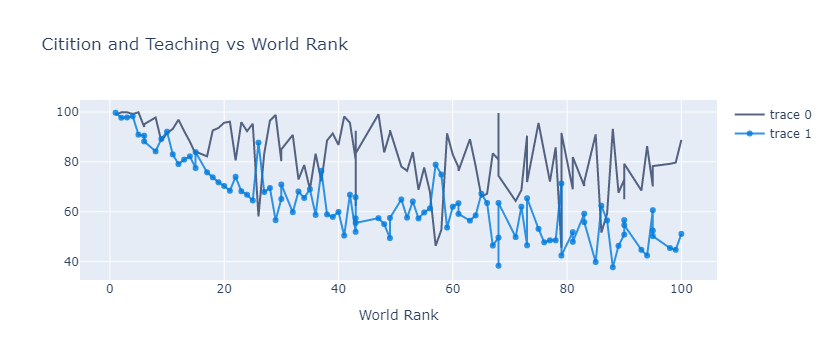

In [15]:
# first line plot for citation
citation = go.Scatter(
x=top_100.world_rank,
y=top_100.citations,
mode = "lines",
marker={"color":"rgba(48, 64, 101, 0.8)"},
text= top_100.university_name)

# second line plot for teaching
teaching = go.Scatter(
x=top_100.world_rank,
y=top_100.teaching,
mode = "lines+markers",
marker=dict(color="rgba(0,123,221,.8)"),
text=top_100.university_name)
data1 = [citation,teaching]
layout = dict(title = "Citition and Teaching vs World Rank", xaxis= dict(title= 'World Rank',ticklen= 5,zeroline= False))
fig = dict(data = data1, layout = layout)
iplot(fig)

This time, we want to see the citation number of 2014, 2015 and 2016 of the top 100 universities (world rank)

In [16]:
rank_2014=university.filter((col("world_rank")<=100)&(col("year")==2014)).toPandas()
rank_2015=university.filter((col("world_rank")<=100)&(col("year")==2015)).toPandas()
rank_2016=university.filter((col("world_rank")<=100)&(col("year")==2016)).toPandas()

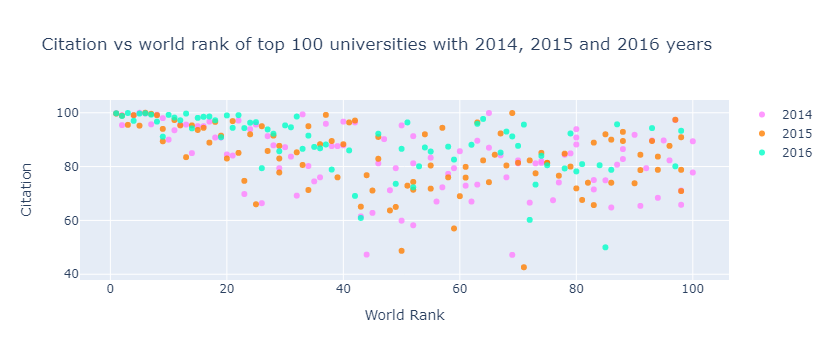

In [17]:
trace1 =go.Scatter(
                    x = rank_2014.world_rank,
                    y = rank_2014.citations,
                    mode = "markers",
                    name = "2014",
                    marker = dict(color = 'rgba(255, 128, 255, 0.8)'),
                    text= rank_2014.university_name)
# creating trace2
trace2 =go.Scatter(
                    x = rank_2015.world_rank,
                    y = rank_2015.citations,
                    mode = "markers",
                    name = "2015",
                    marker = dict(color = 'rgba(255, 128, 2, 0.8)'),
                    text= rank_2015.university_name)
# creating trace3
trace3 =go.Scatter(
                    x = rank_2016.world_rank,
                    y = rank_2016.citations,
                    mode = "markers",
                    name = "2016",
                    marker = dict(color = 'rgba(0, 255, 200, 0.8)'),
                    text= rank_2016.university_name)
data1 = [trace1, trace2, trace3]
layout = dict(title = 'Citation vs world rank of top 100 universities with 2014, 2015 and 2016 years',
              xaxis= dict(title= 'World Rank',ticklen= 5,zeroline= False),
              yaxis= dict(title= 'Citation',ticklen= 5,zeroline= False)
             )
fig = dict(data = data1, layout = layout)
iplot(fig)

# Step 5: Advance data viz (3D Scatter plot)

In below plot, x axis express university world rank, y axis express teaching score,z axis express citiation number, color is research, size is total score in 2016

In [18]:
rank_2016_20 = university.filter((col("world_rank")<=20)&(col("year")==2016)).toPandas()

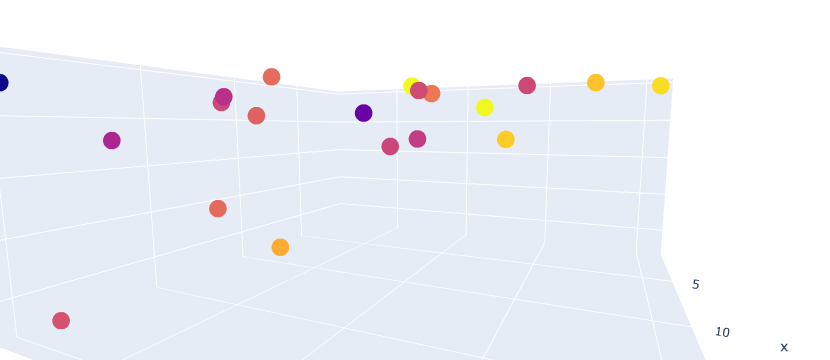

In [19]:
color_3d = rank_2016_20.research
rank_2016_20.total_score = rank_2016_20.total_score.astype(float)
# the size here is the diameter of the circle, it must be numeric
size_3d = rank_2016_20.total_score
trace = go.Scatter3d(
x = rank_2016_20.world_rank,
y = rank_2016_20.teaching,
z = rank_2016_20.citations,
mode = "markers",
# you can replace the size value by size_3d, and check the result
marker = dict ( color = color_3d,size = 10),
text = rank_2016_20.university_name
)
data6 = [trace]
layout = go.Layout(margin = dict(l=0,r=0,b=0,t=0))
fig = go.Figure(data = data6,layout = layout)
iplot(fig)